<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminaries</a></span></li><li><span><a href="#Lecture-overview" data-toc-modified-id="Lecture-overview-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Lecture overview</a></span></li><li><span><a href="#The-data" data-toc-modified-id="The-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The data</a></span></li><li><span><a href="#Descriptive-statistics" data-toc-modified-id="Descriptive-statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Descriptive statistics</a></span></li><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Linear regression</a></span><ul class="toc-item"><li><span><a href="#The-effect-of-outliers" data-toc-modified-id="The-effect-of-outliers-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>The effect of outliers</a></span></li><li><span><a href="#Economic-significance-vs-statistical-significance" data-toc-modified-id="Economic-significance-vs-statistical-significance-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Economic significance vs statistical significance</a></span></li><li><span><a href="#Multicollinearity" data-toc-modified-id="Multicollinearity-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Multicollinearity</a></span></li></ul></li></ul></div>

# Preliminaries

In [1]:
# Import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt

# Lecture overview

To make the concepts in these lecture notes (and the next) more concrete, we will apply them to the empirical analysis of whether firm profitability is predictable. To be more specific, we will ask: 

**Which of the following firm characteristics (if any) have statistically significant predictive power over firms' profitability: the firm's cash holdings, its book leverage or its capital investments?**

In this lecture, we will start by collecting the data we need for this analysis and producing some key descriptive statistics of the data. We will then perform a regression analysis where firm future profitability is the dependent variable, and firm cash holdings, book leverage,and investment are the explanatory variables. In this lecture, we will showcase some common practical issues that one needs to be aware of any time they run a regression:
1. The effect of outliers on our regression results
2. The difference between economic magnitude and statistical significance
3. Multicollinearity (highly correlated independent variables)

In the following lecture, we will continue this analysis by tackling two other very common issues with regression analysis:
1. The potential presence of "fixed-effects" in the data
2. The issue of correlated error terms in the regression

# The data

The first step in our analysis is to decide exactly what data we will use to try to answer this question.
1. We will use the Compustat dataset as raw data (the "compa.zip" file in the "data" folder). 

We then have to be explicit about exactly how each variable in the analysis will be calculated:
1. Dependent variable:
    - roa = net income before extraordinary items (``ib``) divided by total assets (``at``)

2. Independent variables:
    - cash holdings = cash and cash equivalents (``che``) divided by total assets
    - book leverage = long-term debt (``dltt``) divided by total assets
    - capital expenditures = change in net PP\&E (``ppent``) divided by total assets 

Note that all the variables are scaled by some measure of size (total assets). This is to ensure that our regression results are not dominated by large firms. It also helps avoid heteroskedasticity problems (the dollar-amount data for large firms is much more volatile than the data for small firms). 

In [2]:
# Load the cleaned compa data, keeping only what we need
comp = pd.read_pickle('../data/compa.zip')
comp = comp.loc[comp['at']>0, ['permno','datadate','ib','at','che','dltt','ppent','sich']].copy()
comp = comp.sort_values(['permno','datadate'])
comp.dtypes

permno      float64
datadate     object
ib          float64
at          float64
che         float64
dltt        float64
ppent       float64
sich        float64
dtype: object

In [3]:
# Create main variables
comp['year'] = pd.to_datetime(comp['datadate']).dt.year

comp['roa'] = comp['ib'] / comp['at']
comp['future_roa'] = comp.groupby('permno')['roa'].shift(-1)

comp['cash'] = comp['che'] / comp['at']
comp['leverage'] = comp['dltt'] / comp['at']
comp['investment'] = comp.groupby('permno')['ppent'].diff(1) / comp['at']

main_vars = ['future_roa', 'cash', 'leverage', 'investment']

In [4]:
# Winsorize main variables at the 1 and 99 percentiles
for v in main_vars:
    comp['w_' + v] = comp[v].clip(lower = comp[v].quantile(.01),
                                  upper = comp[v].quantile(.99))
comp

,permno,datadate,ib,at,che,dltt,ppent,sich,year,roa,future_roa,cash,leverage,investment,w_future_roa,w_cash,w_leverage,w_investment
188730,10000.0,1986-10-31,-0.730,2.115,0.348,0.058,0.189,NaN,1986,-0.345154,NaN,0.164539,0.027423,NaN,NaN,0.164539,0.027423,NaN
188550,10001.0,1986-06-30,0.669,12.242,0.746,2.946,8.216,NaN,1986,0.054648,0.026506,0.060938,0.240647,NaN,0.026506,0.060938,0.240647,NaN
188566,10001.0,1987-06-30,0.312,11.771,0.729,2.750,8.214,4924.0,1987,0.026506,0.046187,0.061932,0.233625,-0.000170,0.046187,0.061932,0.233625,-0.000170
188567,10001.0,1988-06-30,0.542,11.735,0.744,2.555,7.984,4924.0,1988,0.046187,0.065069,0.063400,0.217725,-0.019599,0.065069,0.063400,0.217725,-0.019599
188568,10001.0,1989-06-30,1.208,18.565,1.177,7.370,14.160,4924.0,1989,0.065069,0.059901,0.063399,0.396984,0.332669,0.059901,0.063399,0.396984,0.332669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493016,93436.0,2016-12-31,-674.914,22664.076,3498.735,6053.860,15036.917,3711.0,2016,-0.029779,-0.068448,0.154374,0.267113,0.434263,-0.068448,0.154374,0.267113,0.361891
493017,93436.0,2017-12-31,-1961.400,28655.372,3523.237,9486.248,20491.616,3711.0,2017,-0.068448,-0.032821,0.122952,0.331046,0.190355,-0.032821,0.122952,0.331046,0.190355
493020,93436.0,2018-12-31,-976.091,29739.614,3878.169,9454.055,19691.231,3711.0,2018,-0.032821,-0.025125,0.130404,0.317894,-0.026913,-0.025125,0.130404,0.317894,-0.026913
493021,93436.0,2019-12-31,-862.000,34309.000,6514.000,12627.000,20199.000,3711.0,2019,-0.025125,0.013826,0.189863,0.368038,0.014800,0.013826,0.189863,0.368038,0.014800


In [5]:
#main_vars_wins = ['w_' + x for x in main_vars]
main_vars_wins = list(comp.filter(like = 'w_').columns)
main_vars_wins

['w_future_roa', 'w_cash', 'w_leverage', 'w_investment']

In [6]:
# Add a constant (column of 1's) and save the data for next time
comp['const'] = 1
comp.to_pickle('../data/comp_clean.zip')

# Descriptive statistics

Summarize the main variables, both winsorized and unwinsorized:

In [7]:
comp[main_vars_wins].describe()

,w_future_roa,w_cash,w_leverage,w_investment
count,212955.000000,236417.000000,235969.000000,207458.000000
mean,-0.044766,0.174446,0.176818,0.014380
std,0.254165,0.218750,0.195127,0.089620
min,-1.482391,0.000181,0.000000,-0.400194
25%,-0.029755,0.025310,0.008017,-0.006815
50%,0.019406,0.080652,0.112543,0.003152
75%,0.061315,0.234988,0.287561,0.033348
max,0.264823,0.930186,0.855270,0.361891


In [8]:
comp[main_vars].describe()

,future_roa,cash,leverage,investment
count,212955.000000,236417.000000,235969.000000,207458.000000
mean,-0.054115,0.174782,0.180717,-0.035447
std,1.568233,0.219955,0.248598,11.025308
min,-218.000000,-0.069190,0.000000,-4110.714102
25%,-0.029755,0.025310,0.008017,-0.006815
50%,0.019406,0.080652,0.112543,0.003152
75%,0.061315,0.234988,0.287561,0.033348
max,226.310379,1.000000,39.592899,0.999933


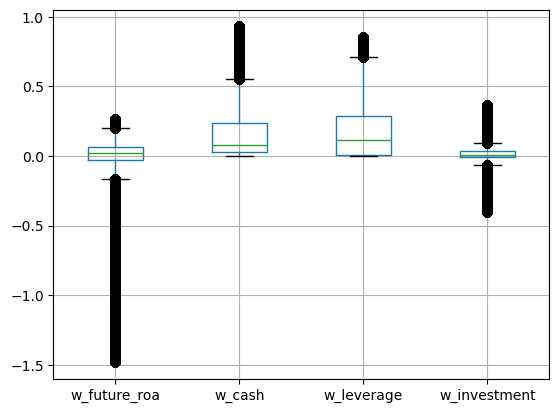

In [9]:
comp[main_vars_wins].boxplot()
plt.show()

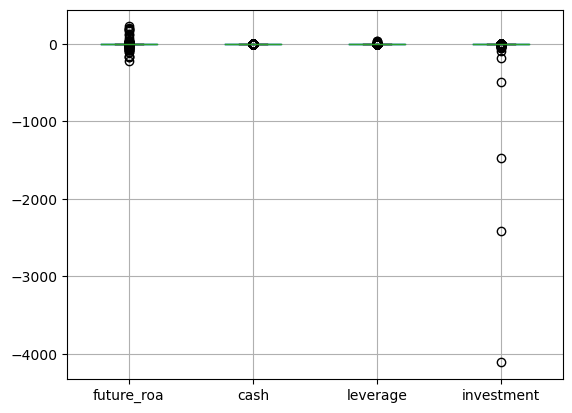

In [10]:
comp[main_vars].boxplot()
plt.show()

Check correlations:

In [23]:
comp[main_vars_wins].corr()

,w_future_roa,w_cash,w_leverage,w_investment
w_future_roa,1.000000,-0.324233,0.063734,0.076357
w_cash,-0.324233,1.000000,-0.315295,-0.070145
w_leverage,0.063734,-0.315295,1.000000,0.074024
w_investment,0.076357,-0.070145,0.074024,1.000000


We can take a look at pairwise scatter plots (to visualize these correlations) using ``pd.plotting.scatter_matrix()``:

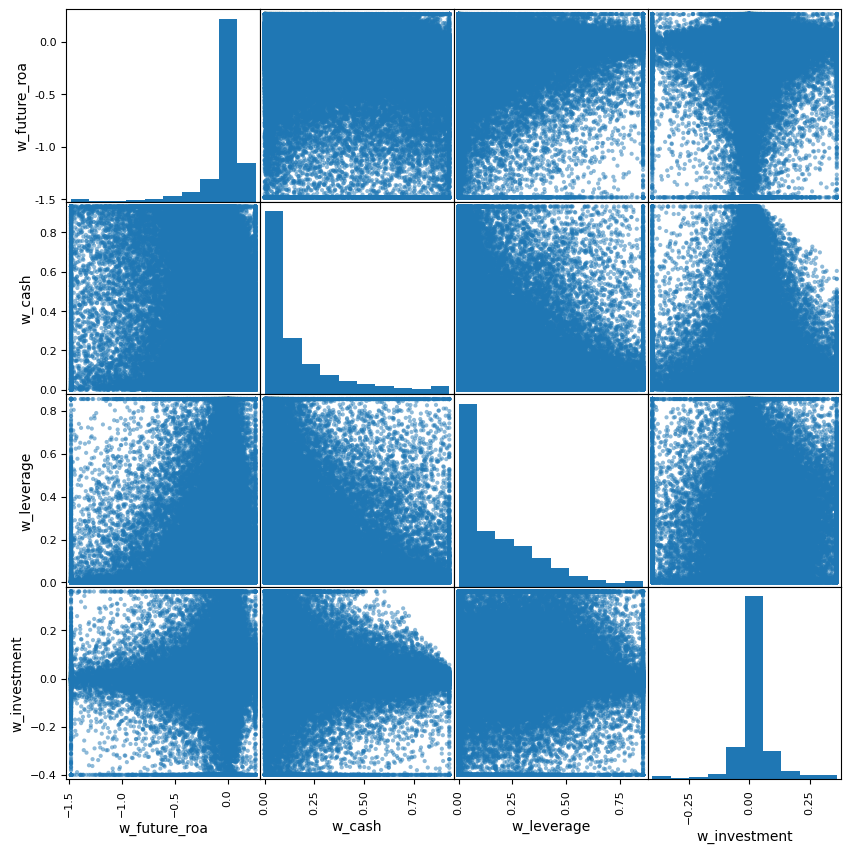

In [22]:
pd.plotting.scatter_matrix(comp[main_vars_wins], figsize=(10,10));
plt.show()

These plots help us realize that point-statistics (single numbers) like the correlation between profitability and cash holdings may mask how rich the data truly is and make us believe that patterns in the data (the -0.32 correlation seems quite strong) are more robust than they really are. Always look at your data (plot it). Just make sure you do it after you mitigate the effect of outliers or the images will look very distorted. 

# Linear regression

Let's use the non-winsorized data first for our baseline regression:

In [27]:
# Using non-winsorized data
results_base = sm.OLS(endog= comp['future_roa'],
                      exog= comp[['const', 'cash', 'leverage', 'investment']],
                      missing='drop').fit()
print(results_base.summary())

                            OLS Regression Results                            
Dep. Variable:             future_roa   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     65.43
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           2.82e-42
Time:                        17:24:20   Log-Likelihood:            -3.4663e+05
No. Observations:              185315   AIC:                         6.933e+05
Df Residuals:                  185311   BIC:                         6.933e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0144      0.006      2.327      0.0

## The effect of outliers

Now let's use the winsorized variables and look at the difference. Check the coefficient on the investment variable in particular.

In [28]:
# Using winsorized data
results_wins = sm.OLS(endog= comp['w_future_roa'],
                      exog= comp[['const', 'w_cash', 'w_leverage', 'w_investment']],
                      missing='drop').fit()
print(results_wins.summary())

                            OLS Regression Results                            
Dep. Variable:           w_future_roa   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     6524.
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:24:31   Log-Likelihood:                 5498.7
No. Observations:              185315   AIC:                        -1.099e+04
Df Residuals:                  185311   BIC:                        -1.095e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0314      0.001     32.312   

## Economic significance vs statistical significance

It is easy to use the results in the regression output above and decide (based on p-values or t-statistics) if the independent variables have a **statistically** significant relation with the dependent variable. But it is not clear if there relations are large or small in magnitude (does investment have a large impact on future profitability? larger than leverage?). That is what we mean by **economically** significant.

To help ease the interpretation of these economic magnitudes, we generally standardize all the variables in the regression by subtracting their mean and dividing by their standard deviation (see below). After doing this, the regression coefficient on any independent variable X, will tell us by how many standard deviations we expect the dependent variable Y to move, when the X variable changes by one standard deviation. 

So after the normalization, the X variables with larger coefficients have a larger economic impact on the Y variable.  

In [29]:
# Create list of names we want to give to the normalized varsions of these variables
normalized_vars = ['n_' + x for x in main_vars]
normalized_vars

['n_future_roa', 'n_cash', 'n_leverage', 'n_investment']

In [30]:
# Create normalized variables
comp[normalized_vars] = (comp[main_vars_wins] - comp[main_vars_wins].mean()) / comp[main_vars_wins].std()

In [31]:
# Check that all means are 0 and all std deviations are 1
comp[normalized_vars].describe()

,n_future_roa,n_cash,n_leverage,n_investment
count,2.129550e+05,2.364170e+05,2.359690e+05,2.074580e+05
mean,-1.388020e-17,6.347540e-17,1.906673e-16,-2.400922e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.656264e+00,-7.966420e-01,-9.061689e-01,-4.625934e+00
25%,5.906184e-02,-6.817643e-01,-8.650839e-01,-2.364965e-01
50%,2.524840e-01,-4.287752e-01,-3.294019e-01,-1.252835e-01
75%,4.173736e-01,2.767601e-01,5.675461e-01,2.116544e-01
max,1.218065e+00,3.454800e+00,3.476980e+00,3.877626e+00


In [33]:
# Using winsorized, then normalized data
results_norm = sm.OLS(endog= comp['n_future_roa'],
                      exog= comp[['const', 'n_cash', 'n_leverage', 'n_investment']],
                      missing='drop').fit()
print(results_norm.summary())

                            OLS Regression Results                            
Dep. Variable:           n_future_roa   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     6524.
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:32:37   Log-Likelihood:            -2.4834e+05
No. Observations:              185315   AIC:                         4.967e+05
Df Residuals:                  185311   BIC:                         4.967e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0037      0.002      1.737   

## Multicollinearity

One common way that multicollinearity arises when two or more of your independent variables (X) are very highly correlated (close to 1). The usual way to deal with this issue, is to calculate the correlation matrix between all the variables in your study, to identify which group of variables are highly correlated with each other. Then we simply drop all but one of them from the analysis.

Below, we artificially create this problem in our example application, by introducing in our regression a variable that equals the leverage variable times 100. This will have a correlation of 1 with the leverage variable. However, as we'll see below, "statsmodels" will NOT give us an error. So it's up to us to make sure that we don't have this problem in our data by always looking at the correlation matrix of our data.

In [36]:
# Add variable that is collinear with size
comp['lev100'] = comp['n_leverage'] * 100

In [37]:
# Run regression with multicollinearity problem
results = sm.OLS(endog= comp['n_future_roa'],
                      exog= comp[['const', 'n_cash', 'n_leverage', 'n_investment', 'lev100']],
                      missing='drop').fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           n_future_roa   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     6524.
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:39:27   Log-Likelihood:            -2.4834e+05
No. Observations:              185315   AIC:                         4.967e+05
Df Residuals:                  185311   BIC:                         4.967e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0037      0.002      1.737   

Note how the coefficient on ``n_leverage`` has changed. Also, look at Notes [2] above.

In [38]:
# Check for correlations to see which which variable to drop
comp[['const', 'n_cash', 'n_leverage', 'n_investment', 'lev100']].corr()

,const,n_cash,n_leverage,n_investment,lev100
const,NaN,NaN,NaN,NaN,NaN
n_cash,NaN,1.000000,-0.315295,-0.070145,-0.315295
n_leverage,NaN,-0.315295,1.000000,0.074024,1.000000
n_investment,NaN,-0.070145,0.074024,1.000000,0.074024
lev100,NaN,-0.315295,1.000000,0.074024,1.000000


Multicollinearity can arise even if a "linear combination" (a weighted sum or difference) of our variables is highly correlated with some other variable in the regression. To see this in action, we will add to our explanatory variables, a variable called ``illiquid`` which measures the non-cash assets of the firm (divided by total assets). In this case, the sum of ``cash`` and ``illiquid`` will equal 1 at all times, which is equal to another explanatory variable in our regression: the constant term.

In [21]:
# Run regression with multicollinearity problem

Again, we did not get an error, but the results above can not be trusted. To see this, you can check Notes [2] above, but you can also print out the correlation matrix. 

Again, dropping one of the problem variables ("cash" or "illiquid") would solve our problem.